In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network
from keras.optimizers import Adam
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook


from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
plotly: 5.9.0


In [2]:
df=pd.read_csv('InSAR_data_south/displacement/export_dataframe1.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y%m%d')
df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-120.9486 34.1347          NaN         NaN         NaN         NaN   
          34.1367          NaN         NaN         NaN         NaN   
          34.1387          NaN         NaN         NaN         NaN   
          34.1407          NaN         NaN         NaN         NaN   
          34.1427          NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
-117.6414 37.6236          0.0      4.8278     -1.3065         NaN   
          37.6256          0.0      4.8698     -1.2137         NaN   
          37.6276          0.0      4.8693     -1.1893         NaN   
          37.6296          0.0      4.8277     -1.1906         NaN   
          37.6316          0.0      4.8729     -1.1200         NaN   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-120.9486 34.1347          NaN         NaN         NaN         NaN   
          34.1367          NaN         NaN         NaN         NaN   
          34.1387          NaN         NaN         NaN         NaN   
          34.1407          NaN         NaN         NaN         NaN   
          34.1427          NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
-117.6414 37.6236      -4.1515     -1.9999      9.9914     -3.1055   
          37.6256      -4.1588     -1.7372     10.4130     -2.9584   
          37.6276      -4.1632     -1.7107     10.4830     -2.9318   
          37.6296      -4.1240     -1.8949     10.1870     -3.0179   
          37.6316      -4.1457     -1.7033     10.5180     -2.9269   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-120.9486 34.1347          NaN         NaN  ...         NaN         NaN   
          34.1367          NaN         NaN  ...         NaN         NaN   
          34.1387          NaN         NaN  ...         NaN         NaN   
          34.1407          NaN         NaN  ...         NaN         NaN   
          34.1427          NaN         NaN  ...         NaN         NaN   
...                        ...         ...  ...         ...         ...   
-117.6414 37.6236     -0.32799      6.9899  ...      8.5800      11.341   
          37.6256     -0.33838      7.3402  ...      9.2515      11.996   
          37.6276     -0.34454      7.3978  ...      8.8321      11.570   
          37.6296     -0.31614      7.1245  ...     10.3320      13.073   
          37.6316     -0.33153      7.3839  ...      9.3376      12.053   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-120.9486 34.1347          NaN         NaN         NaN         NaN   
          34.1367          NaN         NaN         NaN         NaN   
          34.1387          NaN         NaN         NaN         NaN   
          34.1407          NaN         NaN         NaN         NaN   
          34.1427          NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
-117.6414 37.6236       5.5704      7.6113      17.002      9.6014   
          37.6256       6.0621      8.2387      17.526      9.5942   
          37.6276       5.5897      7.8226      17.066      9.2927   
          37.6296       7.2137      9.3699      18.582     10.8610   
          37.6316       6.0863      8.3323      17.499      9.8190   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-120.9486 34.1347          NaN         NaN         NaN         NaN  
          34.1367          NaN         NaN         NaN         NaN  
          34.1387          NaN     

In [3]:
def shaping(datain, timestep):
    
    # Convert input dataframe to array and flatten
    arr=datain.to_numpy().flatten() 
    arr[np.isnan(arr)] = -100
    #print(arr)
    cnt=0
    for mth in range(0, len(datain.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
        cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
        X_start=mth # Start month for inputs of each sample
        X_end=mth+timestep # End month for inputs of each sample
        Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
        Y_end=mth+2*timestep # End month for targets of each sample.  
        
        # Assemble input and target arrays containing all samples
        if mth==0:
            X_comb=arr[X_start:X_end]
            Y_comb=arr[Y_start:Y_end]
        else: 
            X_comb=np.append(X_comb, arr[X_start:X_end])
            Y_comb=np.append(Y_comb, arr[Y_start:Y_end])
    
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, 1))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

In [4]:
##### Step 2 - Prepare data
tup=(-119.9588,35.185)
#tup=(-119.2990,35.8852)
#tup=(-120.2888,34.8349)
#tup=(-117.6414,37.6236)
# Split data into train and test dataframes
df_train_temp=df.iloc[:, :88].copy()
df_test_temp=df.iloc[:, 88:110].copy()
#pick a location to test
df_train = df_train_temp[df_train_temp.index==tup].copy()
df_test = df_test_temp[df_test_temp.index==tup].copy()

print(df_test.index)

MultiIndex([(-119.9588, 35.185)],
           names=['Longitude', 'Latitude'])


In [5]:
tup=(-119.9588,35.185)

data=df[df.index==tup].copy()
print(data.columns[0])
print(data.iloc[0].values.size)
#data=df[df.index==tup].copy()
#data=df.loc(tup)
#data


2014-11-08 00:00:00
110


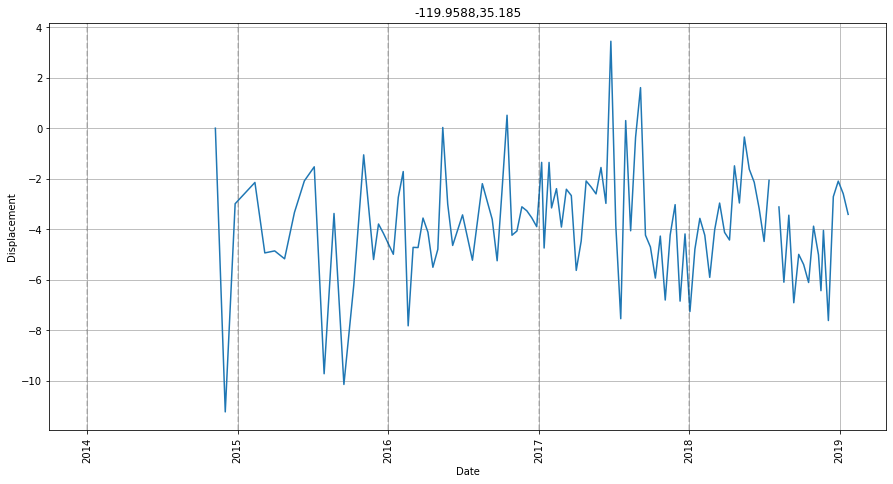

In [6]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data.columns,data.iloc[0].values)
plt.title('-119.9588,35.185')
plt.ylabel('Displacement')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)

for year in range(2014,2019):
    plt.axvline(pd.to_datetime(str(year)+"-01-01"), color='k', linestyle='--', alpha=0.2)
plt.show()

In [7]:
data=data.drop(columns=data.columns[0:3],axis=1)

data=data.drop(columns=data.columns[105:108],axis=1)
data

,,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,2015-07-30,2015-08-23,2015-09-16,...,2018-09-24,2018-10-06,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-119.9588,35.185,-2.1471,-4.9348,-4.855,-5.1682,-3.3311,-2.0852,-1.5282,-9.7155,-3.3747,-10.139,...,-4.9925,-5.3969,-6.1054,-3.8771,-5.0105,-6.429,-4.0435,-7.6104,-2.7098,-2.0944


In [8]:
data=data.transpose()


In [9]:

data = data.set_axis(['data'], axis=1, inplace=False)
#data.insert(0,"date",value=data.index)
data=data.reset_index()
data
print(data)

         index    data
0   2015-02-12 -2.1471
1   2015-03-08 -4.9348
2   2015-04-01 -4.8550
3   2015-04-25 -5.1682
4   2015-05-19 -3.3311
..         ...     ...
100 2018-11-17 -6.4290
101 2018-11-23 -4.0435
102 2018-12-05 -7.6104
103 2018-12-17 -2.7098
104 2018-12-29 -2.0944

[105 rows x 2 columns]


In [10]:
data2=data.resample("M", on="index").first().dropna().reset_index(drop=True)

In [11]:

#data=data.transpose()
data2

#data2 = data.set_axis(['data'], axis=1, inplace=False)
#print(data2)

,index,data
0,2015-02-12,-2.1471
1,2015-03-08,-4.9348
2,2015-04-01,-4.8550
3,2015-05-19,-3.3311
4,2015-06-12,-2.0852
5,2015-07-06,-1.5282
6,2015-08-23,-3.3747
7,2015-09-16,-10.1390
8,2015-10-10,-6.2046
9,2015-11-03,-1.0547


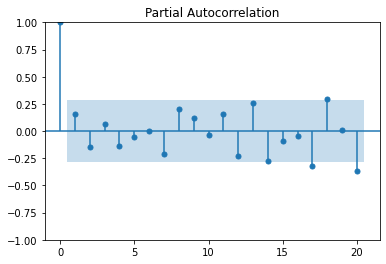

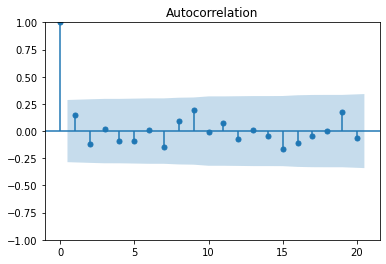

In [12]:
plot_pacf(data2.data.dropna(), lags=20);
plot_acf(data2.data.dropna(), lags=20);

In [13]:
data3=data
data3


,index,data
0,2015-02-12,-2.1471
1,2015-03-08,-4.9348
2,2015-04-01,-4.8550
3,2015-04-25,-5.1682
4,2015-05-19,-3.3311
...,...,...
100,2018-11-17,-6.4290
101,2018-11-23,-4.0435
102,2018-12-05,-7.6104
103,2018-12-17,-2.7098


In [14]:
data3=data3.resample("M", on="index").agg('mean').dropna().reset_index(drop=False)
print(data3)


        index       data
0  2015-02-28  -2.147100
1  2015-03-31  -4.934800
2  2015-04-30  -5.011600
3  2015-05-31  -3.331100
4  2015-06-30  -2.085200
5  2015-07-31  -5.621850
6  2015-08-31  -3.374700
7  2015-09-30 -10.139000
8  2015-10-31  -6.204600
9  2015-11-30  -3.125200
10 2015-12-31  -3.976300
11 2016-01-31  -3.862950
12 2016-02-29  -4.767550
13 2016-03-31  -4.331100
14 2016-04-30  -4.809600
15 2016-05-31  -2.588551
16 2016-06-30  -4.034500
17 2016-07-31  -5.223100
18 2016-08-31  -2.195000
19 2016-09-30  -4.425900
20 2016-10-31  -2.049500
21 2016-11-30  -3.589900
22 2016-12-31  -3.569667
23 2017-01-31  -2.610650
24 2017-02-28  -3.152933
25 2017-03-31  -2.540900
26 2017-04-30  -4.059200
27 2017-05-31  -2.462100
28 2017-06-30  -0.363500
29 2017-07-31  -3.697000
30 2017-08-31  -2.209130
31 2017-09-30  -2.442333
32 2017-10-31  -5.099650
33 2017-11-30  -4.683233
34 2017-12-31  -5.513150
35 2018-01-31  -5.202600
36 2018-02-28  -5.068650
37 2018-03-31  -3.701400
38 2018-04-30  -2.956750


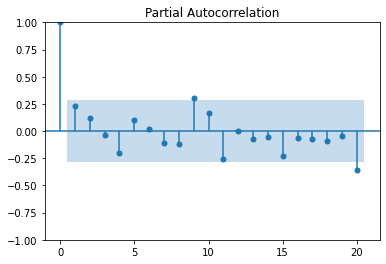

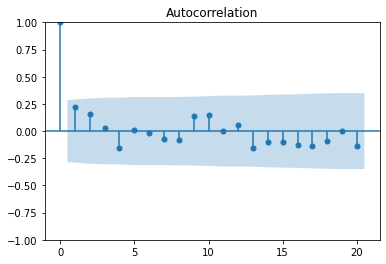

In [15]:
plot_pacf(data3.data.dropna(), lags=20);
plot_acf(data3.data.dropna(), lags=20);

In [20]:

data3.rename(columns={'index':'date'}, inplace=True)
data3

,date,data
0,2015-02-28,-2.147100
1,2015-03-31,-4.934800
2,2015-04-30,-5.011600
3,2015-05-31,-3.331100
4,2015-06-30,-2.085200
5,2015-07-31,-5.621850
6,2015-08-31,-3.374700
7,2015-09-30,-10.139000
8,2015-10-31,-6.204600
9,2015-11-30,-3.125200


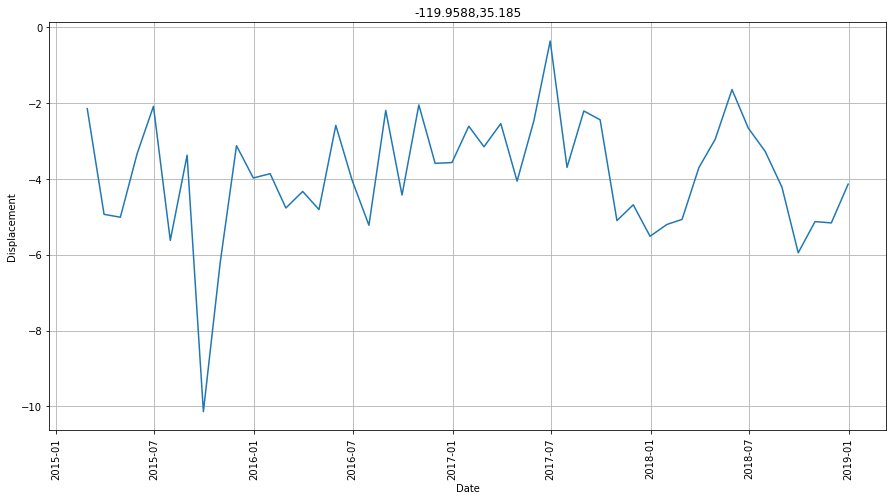

In [22]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data3.date.values,data3.data.values)
plt.title('-119.9588,35.185')
plt.ylabel('Displacement')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)


plt.show()